# Data Sources

Common data sources for predictive maintenance problems are :

* **Failure history:** The failure history of a machine or component within the machine.
* **Maintenance history:** The repair history of a machine, e.g. error codes, previous maintenance activities or component replacements.
* **Machine conditions and usage:** The operating conditions of a machine e.g. data collected from sensors.
* **Machine features:** The features of a machine, e.g. engine size, make and model, location.
* **Operator features:** The features of the operator, e.g. gender, past experience
The data for this example comes from 4 different sources which are real-time telemetry data collected from machines, error messages, historical maintenance records that include failures and machine information such as type and age.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  
from itertools import cycle
from sklearn import metrics
from sklearn import model_selection
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, LabelBinarizer
telemetry = pd.read_csv('PdM_telemetry.csv')
errors = pd.read_csv('PdM_errors.csv')
maint = pd.read_csv('PdM_maint.csv')
failures = pd.read_csv('PdM_failures.csv')
machines = pd.read_csv('PdM_machines.csv')

In [2]:
failures

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4
5,2015-10-17 06:00:00,1,comp2
6,2015-12-16 06:00:00,1,comp4
7,2015-03-19 06:00:00,2,comp1
8,2015-03-19 06:00:00,2,comp2
9,2015-04-18 06:00:00,2,comp2


In [3]:
# format datetime field which comes in as string
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

print("Total number of telemetry records: %d" % len(telemetry.index))
print(telemetry.head())
telemetry.describe()

Total number of telemetry records: 876100
             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration  
0  45.087686  
1  43.413973  
2  34.178847  
3  41.122144  
4  25.990511  


,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


#### **Telemetry**
The first data source is the telemetry time-series data which consists of **voltage, rotation, pressure, and vibration** measurements collected from 100 machines in **real time averaged over every hour collected during the year 2015**. Below, we display the first 10 records in the dataset. A summary of the whole dataset is also provided.

C:\Users\Administrator\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Date')

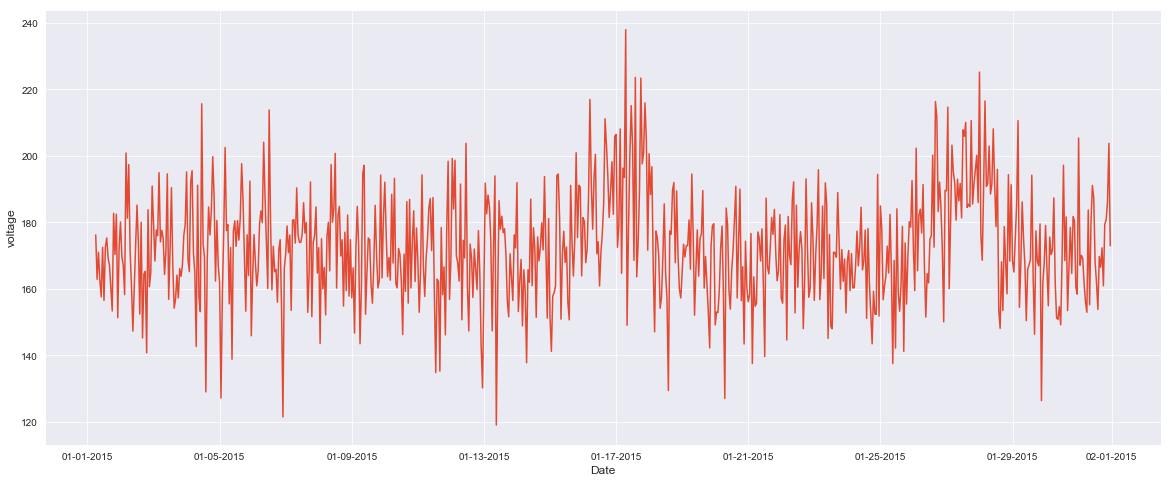

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = telemetry.loc[(telemetry['machineID'] == 1) & 
                        (telemetry['datetime'] > pd.to_datetime('2015-01-01')) & 
                        (telemetry['datetime'] <pd.to_datetime('2015-02-01')),
                        ['datetime','volt']]
sns.set_style("darkgrid")
plt.figure(figsize=(20, 8))
plt.plot(plot_df['datetime'], plot_df['volt'])
plt.ylabel('voltage')

# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
adf.scaled[1.0] = '%m-%d-%Y'
plt.xlabel('Date')

#### **Errors**
The second major data source is the error logs. These are **non-breaking errors thrown while the machine is still operational and do not constitute as failures.** The **error date and times** are rounded to the closest hour since the telemetry data is collected at an hourly rate.

In [5]:
# format of datetime field which comes in as string
errors['datetime'] = pd.to_datetime(errors['datetime'],format = '%Y-%m-%d %H:%M:%S')
errors['errorID'] = errors['errorID'].astype('category')
print("Total Number of error records: %d" %len(errors.index))
errors.head()

Total Number of error records: 3919


,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


error1    1010
error2     988
error3     838
error4     727
error5     356
Name: errorID, dtype: int64

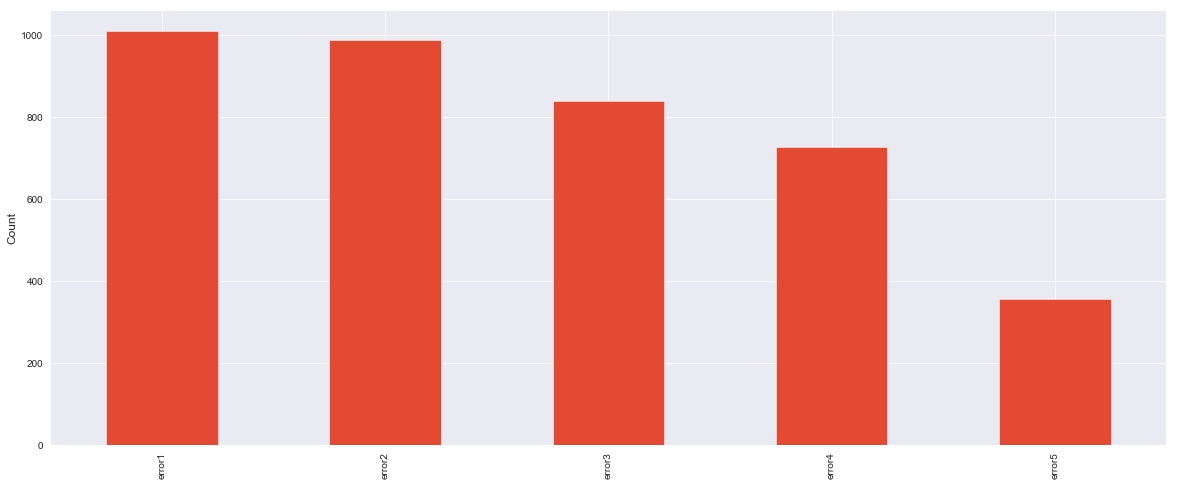

In [6]:
sns.set_style("darkgrid")
plt.figure(figsize=(20, 8))
errors['errorID'].value_counts().plot(kind='bar')
plt.ylabel('Count')
errors['errorID'].value_counts()

#### **Maintenance**
These are the **scheduled and unscheduled** maintenance records which correspond to both **regular inspection of components as well as failures.** A **record is generated if a component is replaced during the scheduled inspection or replaced due to a breakdown.** The **records that are created due to breakdowns will be called failures** which is explained in the later sections. Maintenance data has both 2014 and 2015 records.

In [7]:
maint['datetime'] = pd.to_datetime(maint['datetime'], format='%Y-%m-%d %H:%M:%S')
maint['comp'] = maint['comp'].astype('category')
print("Total Number of maintenance Records: %d" %len(maint.index))
maint.head()

Total Number of maintenance Records: 3286


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


comp2    863
comp4    811
comp3    808
comp1    804
Name: comp, dtype: int64

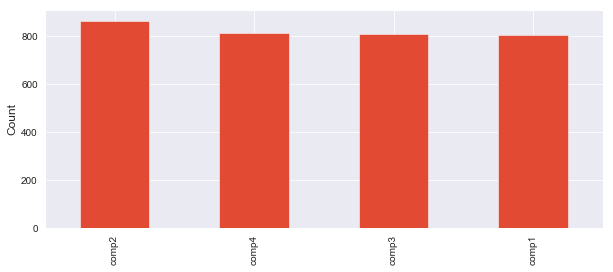

In [8]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 4))
maint['comp'].value_counts().plot(kind='bar')
plt.ylabel('Count')
maint['comp'].value_counts()

#### **Machines**
This data set includes some information about the machines: model type and age (years in service).

In [9]:
machines['model'] = machines['model'].astype('category')

print("Total number of machines: %d" % len(machines.index))
print(machines.head(10))
machines["model"].value_counts()

Total number of machines: 100
   machineID   model  age
0          1  model3   18
1          2  model4    7
2          3  model3    8
3          4  model3    7
4          5  model3    2
5          6  model3    7
6          7  model3   20
7          8  model3   16
8          9  model4    7
9         10  model3   10


model3    35
model4    32
model2    17
model1    16
Name: model, dtype: int64

In [10]:
machines[machines.model=="model3"].head()

,machineID,model,age
0,1,model3,18
2,3,model3,8
3,4,model3,7
4,5,model3,2
5,6,model3,7


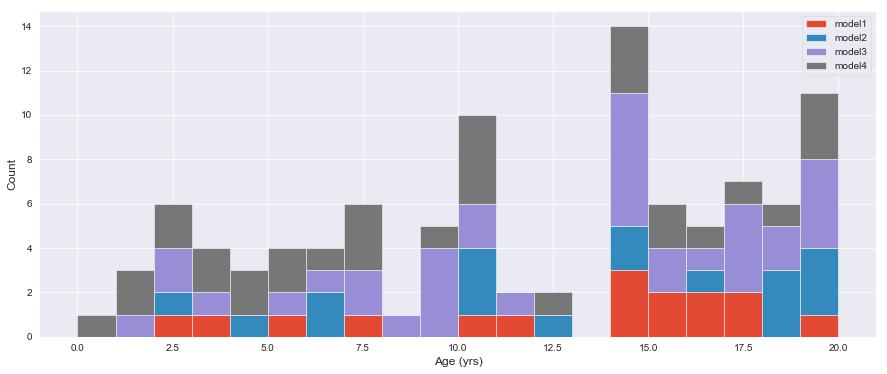

In [11]:
sns.set_style("darkgrid")
plt.figure(figsize=(15, 6))
_, bins, _ = plt.hist([machines.loc[machines['model'] == 'model1', 'age'],
                       machines.loc[machines['model'] == 'model2', 'age'],
                       machines.loc[machines['model'] == 'model3', 'age'],
                       machines.loc[machines['model'] == 'model4', 'age']],
                       20, stacked=True, label=['model1', 'model2', 'model3', 'model4'])
plt.xlabel('Age (yrs)')
plt.ylabel('Count')
plt.legend()

#### **Failures**
These are the records of component replacements **due to failures.** Each record has a **date and time, machine ID, and failed component type.**

In [12]:
# format datetime field which comes in as string
failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

print("Total number of failures: %d" % len(failures.index))
failures.head()

Total number of failures: 761


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


comp2    259
comp1    192
comp4    179
comp3    131
Name: failure, dtype: int64

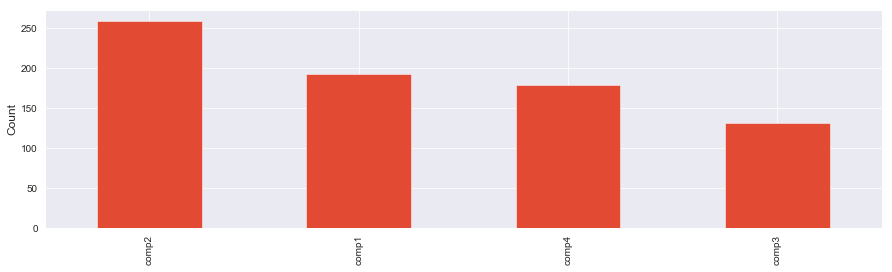

In [13]:
sns.set_style("darkgrid")
plt.figure(figsize=(15, 4))
failures['failure'].value_counts().plot(kind='bar')
plt.ylabel('Count')
failures['failure'].value_counts()

## Feature Engineering
The first step in predictive maintenance applications is feature engineering which requires bringing the different data sources together to create features that best describe a machines's health condition at a given point in time. In the next sections, several feature engineering methods are used to create features based on the properties of each data source.

### Lag Features from Telemetry
Telemetry data almost always comes with time-stamps which makes it suitable for calculating lagging features. A common method is to pick a window size for the lag features to be created and compute rolling aggregate measures such as mean, standard deviation, minimum, maximum, etc. to represent the short term history of the telemetry over the lag window. In the following, rolling mean and standard deviation of the telemetry data over the last 3 hour lag window is calculated for every 3 hours.

In [14]:
# Calculate mean values for telemetry features
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right', how='mean').unstack())
telemetry_mean_3h = pd.concat(temp, axis=1)
telemetry_mean_3h.columns = [i + 'mean_3h' for i in fields]
telemetry_mean_3h.reset_index(inplace=True)

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  


In [15]:
# Calculate mean values for telemetry features
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right', how='mean').unstack())
telemetry_mean_3h = pd.concat(temp, axis=1)
telemetry_mean_3h.columns = [i + 'mean_3h' for i in fields]
telemetry_mean_3h.reset_index(inplace=True)

# repeat for standard deviation
temp = []
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right', how='std').unstack())
telemetry_sd_3h = pd.concat(temp, axis=1)
telemetry_sd_3h.columns = [i + 'sd_3h' for i in fields]
telemetry_sd_3h.reset_index(inplace=True)

telemetry_mean_3h.head()

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).std()


,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542



For capturing a longer term effect, 24 hour lag features are also calculated as below.

In [16]:
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
#     temp.append(pd.rolling_mean(pd.pivot_table(telemetry,
#                                                index='datetime',
#                                                columns='machineID',
#                                                values=col), window=24).resample('3H',
#                                                                                 closed='left',
#                                                                                 label='right',
#                                                                                 how='first').unstack())
    temp.append(pd.pivot_table(telemetry,index='datetime', columns='machineID',values=col).rolling(24).mean().resample('3H', closed='left', label='right',how='first').unstack())
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + 'mean_24h' for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h['voltmean_24h'].isnull()]

# repeat for standard deviation
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
#     temp.append(pd.rolling_std(pd.pivot_table(telemetry,
#                                                index='datetime',
#                                                columns='machineID',
#                                                values=col), window=24).resample('3H',
#                                                                                 closed='left',
#                                                                                 label='right',
#                                                                                 how='first').unstack())
    temp.append(pd.pivot_table(telemetry,index='datetime', columns='machineID',values=col).rolling(12).mean().resample('3H', closed='left', label='right',how='first').unstack())
telemetry_sd_24h = pd.concat(temp, axis=1)
telemetry_sd_24h.columns = [i + 'sd_24h' for i in fields]
telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h['voltsd_24h'].isnull()]
telemetry_sd_24h.reset_index(inplace=True)

# Notice that a 24h rolling average is not available at the earliest timepoints
telemetry_mean_24h.head(10)

temp.append(pd.pivot_table(telemetry,index='datetime', columns='machineID',values=col).rolling(12).mean().resample('3H', closed='left', label='right',how='first').unstack())

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()


Next, the columns of the feature datasets created earlier are merged to create the final feature set from telemetry.

In [17]:
# merge columns of feature sets created earlier
telemetry_feat = pd.concat([telemetry_mean_3h,
                            telemetry_sd_3h.ix[:, 2:6],
                            telemetry_mean_24h.ix[:, 2:6],
                            telemetry_sd_24h.ix[:, 2:6]], axis=1).dropna()
telemetry_feat.describe()

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.ht

,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
count,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000
mean,50.449139,170.772925,446.612347,100.856633,40.384617,13.299887,44.454275,8.885903,4.440606,170.774147,446.612661,100.855848,40.384893,170.776125,446.612223,100.858913,40.384785
std,28.837282,9.497730,33.120579,7.410155,3.477081,6.966157,23.214803,4.656199,2.319968,4.718204,18.070770,4.734936,2.060600,5.744394,21.294568,5.337807,2.366894
min,1.000000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,155.812721,266.010419,91.057429,35.060087,149.787183,259.331320,86.514735,33.873889
25%,25.000000,164.446939,427.566942,96.238748,38.147802,8.028211,26.903641,5.370319,2.684507,168.071562,441.545681,98.669073,39.354134,167.249641,438.456054,98.118115,39.080970
50%,50.000000,170.431869,448.382098,100.234223,40.146196,12.495859,41.794255,8.346071,4.173592,170.212026,449.209131,100.098399,40.072798,170.243499,449.057370,100.121090,40.089686
75%,75.000000,176.608299,468.444732,104.404940,42.227507,17.688520,59.094108,11.789796,5.898735,172.461050,456.367391,101.612066,40.833484,173.393854,459.137561,102.224798,41.141786
max,100.000000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,220.782618,499.096975,152.310351,61.932124,225.031674,520.809846,156.601560,63.568548


In [18]:
telemetry_feat.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
7,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,172.715689,442.094992,96.870302,39.493083
8,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,173.652053,442.159534,99.526346,38.835177
9,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,164.945874,447.753088,102.620828,39.701883
10,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,165.462846,447.854430,102.682079,39.037016
11,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,166.830213,452.909937,101.141590,39.286368


### Lag Features from Errors
Like telemetry data, errors come with timestamps. An important difference is that the **error IDs are categorical values** and **should not be averaged over time intervals like the telemetry measurements.** Instead, we count the number of errors of each type in a **lagging window. We begin by reformatting the error data** to have one entry per machine per time at which at least one error occurred:

In [19]:
errors

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4
5,2015-01-25 15:00:00,1,error4
6,2015-01-27 04:00:00,1,error1
7,2015-03-03 22:00:00,1,error2
8,2015-03-05 06:00:00,1,error1
9,2015-03-20 18:00:00,1,error1


In [20]:
# create a column for each error type
error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
error_count
error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']
error_count.head(13)

,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-03 07:00:00,1,1,0,0,0,0
1,2015-01-03 20:00:00,1,0,0,1,0,0
2,2015-01-04 06:00:00,1,0,0,0,0,1
3,2015-01-10 15:00:00,1,0,0,0,1,0
4,2015-01-22 10:00:00,1,0,0,0,1,0
5,2015-01-25 15:00:00,1,0,0,0,1,0
6,2015-01-27 04:00:00,1,1,0,0,0,0
7,2015-03-03 22:00:00,1,0,1,0,0,0
8,2015-03-05 06:00:00,1,1,0,0,0,0
9,2015-03-20 18:00:00,1,1,0,0,0,0


In [21]:
# combine errors for a given machine in a given hour
error_count = error_count.groupby(['machineID','datetime']).sum().reset_index()
error_count.head(13)

,machineID,datetime,error1,error2,error3,error4,error5
0,1,2015-01-03 07:00:00,1,0,0,0,0
1,1,2015-01-03 20:00:00,0,0,1,0,0
2,1,2015-01-04 06:00:00,0,0,0,0,1
3,1,2015-01-10 15:00:00,0,0,0,1,0
4,1,2015-01-22 10:00:00,0,0,0,1,0
5,1,2015-01-25 15:00:00,0,0,0,1,0
6,1,2015-01-27 04:00:00,1,0,0,0,0
7,1,2015-03-03 22:00:00,0,1,0,0,0
8,1,2015-03-05 06:00:00,1,0,0,0,0
9,1,2015-03-20 18:00:00,1,0,0,0,0


In [22]:
error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)
error_count.describe()

,machineID,error1,error2,error3,error4,error5
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,0.001153,0.001128,0.000957,0.000830,0.000406
std,28.866087,0.033934,0.033563,0.030913,0.028795,0.020154
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.250000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Finally, we can compute the total number of errors of each type over the last 24 hours, for timepoints taken every three hours:

In [23]:
temp = []
fields = ['error%d' % i for i in range(1,6)]
for col in fields:
    temp.append(pd.pivot_table(error_count,index='datetime',columns='machineID', values=col).rolling(24).sum().resample('3H',
                                                                             closed='left',
                                                                             label='right',
                                                                             how='first').unstack())
error_count = pd.concat(temp, axis=1)
error_count.columns = [i + 'count' for i in fields]
error_count.reset_index(inplace=True)
error_count = error_count.dropna()
error_count.describe()

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
  import sys


,machineID,error1count,error2count,error3count,error4count,error5count
count,291400.00000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000
mean,50.50000,0.027649,0.027069,0.022907,0.019904,0.009753
std,28.86612,0.166273,0.164429,0.151453,0.140820,0.098797
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,2.000000,2.000000,2.000000,2.000000,2.000000


In [24]:
error_count.head()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
7,1,2015-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0
8,1,2015-01-02 09:00:00,0.0,0.0,0.0,0.0,0.0
9,1,2015-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0
10,1,2015-01-02 15:00:00,0.0,0.0,0.0,0.0,0.0
11,1,2015-01-02 18:00:00,0.0,0.0,0.0,0.0,0.0


### Days Since Last Replacement from Maintenance
A crucial data set in this example is the maintenance records which contain the information of component replacement records. Possible features from this data set can be, for example, the number of replacements of each component in the last 3 months to incorporate the frequency of replacements. However, more relevent information would be to calculate how long it has been since a component is last replaced as that would be expected to correlate better with component failures since the longer a component is used, the more degradation should be expected.

As a side note, creating lagging features from maintenance data is not as straightforward as for telemetry and errors, so the features from this data are generated in a more custom way. This type of ad-hoc feature engineering is very common in predictive maintenance since domain knowledge plays a big role in understanding the predictors of a problem. In the following, the days since last component replacement are calculated for each component type as features from the maintenance data.

In [25]:
import numpy as np

# create a column for each error type
comp_rep = pd.get_dummies(maint.set_index('datetime')).reset_index()
comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']

# combine repairs for a given machine in a given hour
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

# add timepoints where no components were replaced
comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    # convert indicator to most recent date of component change
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
    
    # forward-fill the most-recent date of component change
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')

# remove dates in 2014 (may have NaN or future component change dates)    
comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

# replace dates of most recent component change with days since most recent component change
for comp in components:
    comp_rep[comp] = (comp_rep['datetime'] - comp_rep[comp].astype('<M8[ns]')) / np.timedelta64(1, 'D')
    
comp_rep.describe()

,machineID,comp1,comp2,comp3,comp4
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,53.525185,51.540806,52.725962,53.834191
std,28.866087,62.491679,59.269254,58.873114,59.707978
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,13.291667,12.125000,13.125000,13.000000
50%,50.500000,32.791667,29.666667,32.291667,32.500000
75%,75.250000,68.708333,66.541667,67.333333,70.458333
max,100.000000,491.958333,348.958333,370.958333,394.958333


In [26]:
np.timedelta64(1,'W')

numpy.timedelta64(1,'W')

In [27]:
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 07:00:00,1,19.041667,214.041667,154.041667,169.041667
2,2015-01-01 08:00:00,1,19.083333,214.083333,154.083333,169.083333
3,2015-01-01 09:00:00,1,19.125000,214.125000,154.125000,169.125000
4,2015-01-01 10:00:00,1,19.166667,214.166667,154.166667,169.166667


## Machine Features
The machine features can be used without further modification. These include descriptive information about the type of each machine and its age (number of years in service). If the age information had been recorded as a "first use date" for each machine, a transformation would have been necessary to turn those into a numeric values indicating the years in service.

Lastly, we merge all the feature data sets we created earlier to get the final feature matrix.

In [28]:
telemetry_feat

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
7,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,172.715689,442.094992,96.870302,39.493083
8,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,173.652053,442.159534,99.526346,38.835177
9,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,164.945874,447.753088,102.620828,39.701883
10,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,165.462846,447.854430,102.682079,39.037016
11,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,166.830213,452.909937,101.141590,39.286368
12,1,2015-01-02 21:00:00,163.278466,446.493166,104.387585,38.068116,21.580492,41.380958,20.725597,6.932127,170.556674,452.267095,98.065860,40.033247,168.149071,465.569660,102.228337,38.557273
13,1,2015-01-03 00:00:00,172.191198,434.214692,93.747282,39.716482,16.369836,14.636041,18.817326,3.426997,168.460525,451.031783,99.273286,38.903462,174.120439,461.817056,97.480306,39.197585
14,1,2015-01-03 03:00:00,175.210027,504.845430,108.512153,37.763933,5.991921,16.062702,6.382608,3.449468,169.772951,447.502464,99.005946,39.389725,176.269181,479.888152,96.039184,42.496263
15,1,2015-01-03 06:00:00,181.690108,472.783187,93.395164,38.621099,11.514450,47.880443,2.177029,7.670520,170.900562,453.864597,100.877342,38.696225,175.253089,474.492644,96.790164,45.507331
16,1,2015-01-03 09:00:00,172.382935,505.141261,98.524373,49.965572,7.065150,56.849540,5.230039,2.687565,169.533156,454.785072,100.050567,39.449734,174.339994,463.071566,95.478041,50.660355


In [29]:
final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(machines, on=['machineID'], how='left')

print(final_feat.head())
final_feat.describe()

   machineID            datetime  voltmean_3h  rotatemean_3h  pressuremean_3h  \
0          1 2015-01-02 06:00:00   180.133784     440.608320        94.137969   
1          1 2015-01-02 09:00:00   176.364293     439.349655       101.553209   
2          1 2015-01-02 12:00:00   160.384568     424.385316        99.598722   
3          1 2015-01-02 15:00:00   170.472461     442.933997       102.380586   
4          1 2015-01-02 18:00:00   163.263806     468.937558       102.726648   

   vibrationmean_3h  voltsd_3h  rotatesd_3h  pressuresd_3h  vibrationsd_3h  \
0         41.551544  21.322735    48.770512       2.135684       10.037208   
1         36.105580  18.952210    51.329636      13.789279        6.737739   
2         36.094637  13.047080    13.702496       9.988609        1.639962   
3         40.483002  16.642354    56.290447       3.305739        8.854145   
4         40.921802  17.424688    38.680380       9.105775        3.060781   

   ...  error2count  error3count  error4coun

,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,...,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,age
count,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000,...,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000,291001.000000
mean,50.449139,170.772925,446.612347,100.856633,40.384617,13.299887,44.454275,8.885903,4.440606,170.774147,...,0.027660,0.027076,0.022869,0.019928,0.009766,53.339421,51.317662,52.499919,53.638891,11.336504
std,28.837282,9.497730,33.120579,7.410155,3.477081,6.966157,23.214803,4.656199,2.319968,4.718204,...,0.166306,0.164449,0.151338,0.140903,0.098864,62.448164,59.140673,58.793839,59.633304,5.827083
min,1.000000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,155.812721,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,164.446939,427.566942,96.238748,38.147802,8.028211,26.903641,5.370319,2.684507,168.071562,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.250000,12.000000,13.000000,12.875000,7.000000
50%,50.000000,170.431869,448.382098,100.234223,40.146196,12.495859,41.794255,8.346071,4.173592,170.212026,...,0.000000,0.000000,0.000000,0.000000,0.000000,32.625000,29.500000,32.000000,32.375000,12.000000
75%,75.000000,176.608299,468.444732,104.404940,42.227507,17.688520,59.094108,11.789796,5.898735,172.461050,...,0.000000,0.000000,0.000000,0.000000,0.000000,68.375000,66.125000,67.000000,70.125000,16.000000
max,100.000000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,220.782618,...,2.000000,2.000000,2.000000,2.000000,2.000000,491.875000,348.875000,370.875000,394.875000,20.000000


# Label Construction
When using multi-class classification for predicting failure due to a problem, labelling is done by taking a time window prior to the failure of an asset and labelling the feature records that fall into that window as "about to fail due to a problem" while labelling all other records as "Â€Âœnormal." This time window should be picked according to the business case: in some situations it may be enough to predict failures hours in advance, while in others days or weeks may be needed to allow e.g. for arrival of replacement parts.

The prediction problem for this example scenerio is to estimate the probability that a machine will fail in the near future due to a failure of a certain component. More specifically, the goal is to compute the probability that a machine will fail in the next 24 hours due to a certain component failure (component 1, 2, 3, or 4). Below, a categorical failure feature is created to serve as the label. All records within a 24 hour window before a failure of component 1 have failure=comp1, and so on for components 2, 3, and 4; all records not within 24 hours of a component failure have failure=none.

In [30]:
labeled_features = final_feat.merge(failures, on=['datetime', 'machineID'], how='left')
# labeled_features = labeled_features.fillna(method='bfill', limit=7) # fill backward up to 24h
# labeled_features = labeled_features.fillna('none')
labeled_features['error1count'] = labeled_features['error1count'].fillna(0)
labeled_features['error2count'] = labeled_features['error2count'].fillna(0)
labeled_features['error3count'] = labeled_features['error3count'].fillna(0)
labeled_features['error4count'] = labeled_features['error4count'].fillna(0)
labeled_features['error5count'] = labeled_features['error5count'].fillna(0)

labeled_features['failure'] =labeled_features['failure'].astype(object)
labeled_features['failure'] = labeled_features['failure'].fillna(0)

labeled_features.loc[labeled_features.failure == 'comp1', 'failure'] = 1
labeled_features.loc[labeled_features.failure == 'comp2', 'failure'] = 2
labeled_features.loc[labeled_features.failure == 'comp3', 'failure'] = 3
labeled_features.loc[labeled_features.failure == 'comp4', 'failure'] = 4
# labeled_features.head()

In [31]:
labeled_features.failure.isna().value_counts()

False    291042
Name: failure, dtype: int64

In [32]:
labeled_features.failure.value_counts()

0    290300
2       255
1       183
4       176
3       128
Name: failure, dtype: int64

Below is an example of records that are labeled as failure=comp4 in the failure column. Notice that the first 8 records all occur in the 24-hour window before the first recorded failure of component 4. The next 8 records are within the 24 hour window before another failure of component 4.

In [33]:
# labeled_features.loc[labeled_features['failure'] == 4][:16]

In [34]:
# plt.figure(figsize=(8,7))
# sns.set(style="darkgrid")
# sns.countplot(x="failure", data=labeled_features)

In [35]:
# labeled_features['failure'].value_counts()

In [36]:
# labeled_features['failure'].count()

# Modelling
After the feature engineering and labelling steps, either Azure Machine Learning Studio or this notebook can be used to create a predictive model. The recommend Azure Machine Learning Studio experiment can be found in the Cortana Intelligence Gallery: Predictive Maintenance Modelling Guide Experiment. Below, we describe the modelling process and provide an example Python model.

# Training, Validation and Testing
When working with time-stamped data as in this example, record partitioning into training, validation, and test sets should be performed carefully to prevent overestimating the performance of the models. In predictive maintenance, the features are usually generated using lagging aggregates: records in the same time window will likely have identical labels and similar feature values. These correlations can give a model an "unfair advantage" when predicting on a test set record that shares its time window with a training set record. We therefore partition records into training, validation, and test sets in large chunks, to minimize the number of time intervals shared between them.

Predictive models have no advance knowledge of future chronological trends: in practice, such trends are likely to exist and to adversely impact the model's performance. To obtain an accurate assessment of a predictive model's performance, we recommend training on older records and validating/testing using newer records.

For both of these reasons, a time-dependent record splitting strategy is an excellent choice for predictive maintenace models. The split is effected by choosing a point in time based on the desired size of the training and test sets: all records before the timepoint are used for training the model, and all remaining records are used for testing. (If desired, the timeline could be further divided to create validation sets for parameter selection.) To prevent any records in the training set from sharing time windows with the records in the test set, we remove any records at the boundary -- in this case, by ignoring 24 hours' worth of data prior to the timepoint.

In [37]:


# make test and training splits
threshold_dates = [[pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')],
#                    [pd.to_datetime('2015-08-31 01:00:00'), pd.to_datetime('2015-09-01 01:00:00')],
#                    [pd.to_datetime('2015-09-30 01:00:00'), pd.to_datetime('2015-10-01 01:00:00')]
                  ]

test_results = []
models = []
for last_train_date, first_test_date in threshold_dates:
    # split out training and test data
    y_train = labeled_features.loc[labeled_features['datetime'] < last_train_date, 'failure']
    df_train = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['datetime',
                                                                                                        'machineID',
                                                                                                        'failure'], 1))
    df_test = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] > first_test_date].drop(['datetime',
                                                                                                       'machineID',
                                                                                                       'failure'], 1))
    y_test = labeled_features.loc[labeled_features['datetime'] > first_test_date, 'failure']


In [38]:

# df_train=df_train.head(100)
# df_test=df_test.head(100)
# y_train=y_train.head(100)
# y_test=y_test.head(100)


In [39]:
# original features
features_orig = ['voltmean_3h','rotatemean_3h','pressuremean_3h']

# original + extracted fetures
features_extr = ['voltmean_3h','rotatemean_3h','pressuremean_3h']
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_train

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [40]:
def multiclass_classify(model, clf, features, params=None, score=None, scale=False, OvR=True, prob='P'):
       
    """Perfor Grid Search hyper parameter tuning on a classifier.
    
    Args:
        model (str): The model name identifier
        clf (clssifier object): The classifier to be tuned
        features (list): The set of input features names
        params (dict): Grid Search parameters
        score (str): Grid Search score
        OvR (bool): True if the classifier inherently support multiclass One-Vs-Rest
        prob (str): For getting classification scores: 'P' for predict_proba, 'D' for decision_function
        
    Returns:
        Tuned Clssifier object
        array: prediction values
        array: prediction scores
    
    
    """
    
    
    X_train = df_train[features]

    X_test = df_test[features] 
    
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    if prob == 'P':   
        y_score = grid_search.predict_proba(X_test)
        if OvR:    
            y_score = [y_score[i][:,[1]] for i in range(len(y_score))]
            y_score = np.concatenate(y_score, axis=1)
    elif prob == 'D':
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred
        
    
    return grid_search.best_estimator_, y_pred, y_score


In [41]:
def multiclass_metrics(model, y_test, y_pred, y_score, print_out=True, plot_out=True):
    
    """Calculate main multiclass classifcation metrics, plot AUC ROC and Precision-Recall curves.
    
    Args:
        model (str): The model name identifier
        y_test (series): Contains the test label values
        y_pred (series): Contains the predicted values
        y_score (series): Contains the predicted scores
        print_out (bool): Print the classification metrics and thresholds values
        plot_out (bool): Plot AUC ROC, Precision-Recall, and Threshold curves
        
    Returns:
        dataframe: The combined metrics in single dataframe
        dict: ROC thresholds
        dict: Precision-Recall thresholds
        Plot: AUC ROC
        plot: Precision-Recall
  
    
    """
    multiclass_metrics = {
                            'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                            'macro F1' : metrics.f1_score(y_test, y_pred, average='macro'),
                            'micro F1' : metrics.f1_score(y_test, y_pred, average='micro'),
                            'macro Precision' : metrics.precision_score(y_test, y_pred,  average='macro'),
                            'micro Precision' : metrics.precision_score(y_test, y_pred,  average='micro'),
                            'macro Recall' : metrics.recall_score(y_test, y_pred,  average='macro'),
                            'micro Recall' : metrics.recall_score(y_test, y_pred,  average='micro'),
                            'macro ROC AUC' : metrics.roc_auc_score(y_test, y_score, average='macro'),
                            'micro ROC AUC' : metrics.roc_auc_score(y_test, y_score, average='micro')
                        }
    
    df_metrics = pd.DataFrame.from_dict(multiclass_metrics, orient='index')
    df_metrics.columns = [model]

   
    n_classes = y_train.shape[1]
    
    fpr = dict()
    tpr = dict()
    thresh_roc = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        #fpr[i], tpr[i], thresh_roc[i] = metrics.roc_curve(y_test[:, i], y_score[i][:,0])
        fpr[i], tpr[i], thresh_roc[i] = metrics.roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
    fpr["micro"], tpr["micro"], thresh_roc["micro"] = metrics.roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    

    roc_thresh = {
                    'Threshold' : thresh_roc,
                    'TPR' : tpr,
                    'FPR' : fpr,
                    'AUC' : roc_auc
                 }
    
    df_roc_thresh = pd.DataFrame.from_dict(roc_thresh)
    df_roc_thresh['Model'] = model
    df_roc_thresh['Class'] = df_roc_thresh.index
    
    
    
    precision = dict()
    recall = dict()
    thresh_prc = dict()
    average_precision = dict()
    
    for i in range(n_classes):
        #precision[i], recall[i], thresh_prc[i] = metrics.precision_recall_curve(y_test[:, i], y_score[i][:,0])
        precision[i], recall[i], thresh_prc[i] = metrics.precision_recall_curve(y_test[:, i], y_score[:, i])
        average_precision[i] = metrics.average_precision_score(y_test[:, i], y_score[:, i])

    precision["micro"], recall["micro"], thresh_prc["micro"] = metrics.precision_recall_curve(y_test.ravel(), y_score.ravel())
    average_precision["micro"] = metrics.average_precision_score(y_test, y_score, average="micro")
    
    prc_thresh = {
                    'Threshold' : thresh_prc,
                    'Precision' : precision,
                    'Recall' : recall,
                    'Avg Precision' : average_precision
                 }

    df_prc_thresh = pd.DataFrame.from_dict(prc_thresh)
    df_prc_thresh['Model'] = model
    df_prc_thresh['Class'] = df_prc_thresh.index    
    
    y_test_orig = lb.inverse_transform(y_test)
    y_pred_orig = lb.inverse_transform(y_pred)
    
    if print_out:
        print('-----------------------------------------------------------')
        print(model, '\n')
        print('Confusion Matrix:')
        print(metrics.confusion_matrix(y_test_orig, y_pred_orig))
        print('\nClassification Report:')
        print(metrics.classification_report(y_test_orig, y_pred_orig))
        print('\nMetrics:')
        print(df_metrics)

    if plot_out:
        
        colors = cycle(['red', 'green', 'blue'])
        
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False )
        fig.set_size_inches(12,6)
        
        for i, color in zip(range(n_classes), colors):
            ax1.plot(fpr[i], tpr[i], color=color, lw=1, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
        
        ax1.plot(fpr["micro"], tpr["micro"], color='deeppink', label='micro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["micro"]), linestyle=':', linewidth=4)
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax1.set_xlim([-0.05, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend(loc="lower right", fontsize='small')
        
        
        for i, color in zip(range(n_classes), colors):
            ax2.plot(recall[i], precision[i], color=color, lw=1, label='Precision-recall curve of class {0} (area = {1:0.2f})'.format(i, average_precision[i]))
            
        ax2.plot(recall["micro"], precision["micro"], color='deeppink', lw=4, linestyle=':', label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.legend(loc="lower left", fontsize='small')
    
    return df_metrics, df_prc_thresh, df_roc_thresh


Best Parameters:
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


-----------------------------------------------------------
Decision Tree B 

Confusion Matrix:
[[122014      0      0      0      4]
 [    66      0      0      0      0]
 [   111      0      0      0      0]
 [    52      0      0      0      0]
 [    73      0      0      0      0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    122018
           1       0.00      0.00      0.00        66
           2       0.00      0.00      0.00       111
           3       0.00      0.00      0.00        52
           4       0.00      0.00      0.00        73

    accuracy                           1.00    122320
   macro avg       0.20      0.20      0.20    122320
weighted avg       1.00      1.00      1.00    122320


Metrics:
                 Decision Tree B
Accuracy                0.997482
macro F1                0.199748
micro F1                0.997490
macro Precision         0.199506
micro Precision         0

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


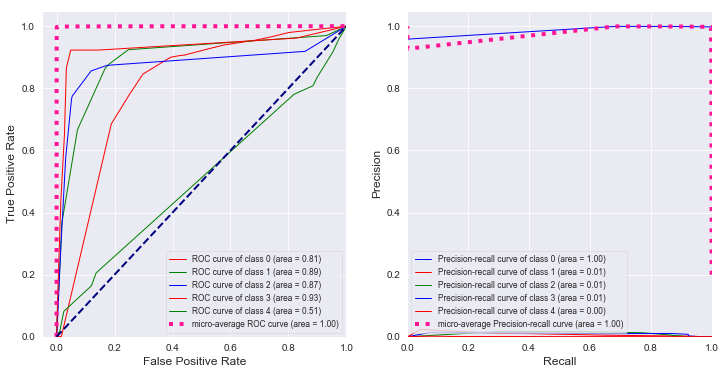

In [42]:
model = 'Decision Tree B'
clf_dtrb = DecisionTreeClassifier(random_state=123)
gs_params = {'max_depth': [ 4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'

clf_dtrb, y_pred_dtrb, y_score_dtrb = multiclass_classify(model, clf_dtrb, features_orig, params=gs_params, score=gs_score, scale=False, OvR=True, prob='P')
print('\nBest Parameters:\n',clf_dtrb)

metrics_dtrb, prc_dtrb, roc_dtrb = multiclass_metrics(model, y_test, y_pred_dtrb, y_score_dtrb, print_out=True, plot_out=True)


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of ite


Best Parameters:
 OneVsRestClassifier(estimator=LinearSVC(C=0.1, class_weight=None, dual=True,
                                        fit_intercept=True, intercept_scaling=1,
                                        loss='squared_hinge', max_iter=1000,
                                        multi_class='ovr', penalty='l2',
                                        random_state=123, tol=0.0001,
                                        verbose=0),
                    n_jobs=None)


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


-----------------------------------------------------------
SVC Linear B 

Confusion Matrix:
[[122018      0      0      0      0]
 [    66      0      0      0      0]
 [   111      0      0      0      0]
 [    52      0      0      0      0]
 [    73      0      0      0      0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    122018
           1       0.00      0.00      0.00        66
           2       0.00      0.00      0.00       111
           3       0.00      0.00      0.00        52
           4       0.00      0.00      0.00        73

    accuracy                           1.00    122320
   macro avg       0.20      0.20      0.20    122320
weighted avg       1.00      1.00      1.00    122320


Metrics:
                 SVC Linear B
Accuracy             0.997531
macro F1             0.199753
micro F1             0.997531
macro Precision      0.199506
micro Precision      0.997531
macro Recall 

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


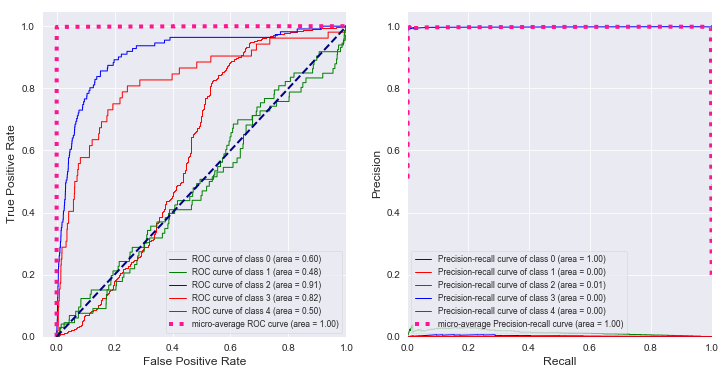

In [43]:
model = 'SVC Linear B'

clf_svlb = OneVsRestClassifier(LinearSVC(random_state=123))
gs_params = {'estimator__C': [.01, 0.1, 1.0]}
gs_score = 'roc_auc'


clf_svlb, y_pred_svlb, y_score_svlb = multiclass_classify(model, clf_svlb, features_orig, params=gs_params, score=gs_score, scale=False, OvR=False, prob='D')
print('\nBest Parameters:\n',clf_svlb)

metrics_svlb, prc_svlb, roc_svlb = multiclass_metrics(model, y_test, y_pred_svlb, y_score_svlb, print_out=True, plot_out=True)


# Evaluation
In predictive maintenance, machine failures are usually rare occurrences in the lifetime of the assets compared to normal operation. This causes an imbalance in the label distribution which usually causes poor performance as algorithms tend to classify majority class examples better at the expense of minority class examples as the total misclassification error is much improved when majority class is labeled correctly. This causes low recall rates although accuracy can be high and becomes a larger problem when the cost of false alarms to the business is very high. To help with this problem, sampling techniques such as oversampling of the minority examples are usually used along with more sophisticated techniques which are not covered in this notebook.


Best Parameters:
 OneVsRestClassifier(estimator=LogisticRegression(C=0.1, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=123,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


-----------------------------------------------------------
Logistic Regression B 

Confusion Matrix:
[[122018      0      0      0      0]
 [    66      0      0      0      0]
 [   111      0      0      0      0]
 [    52      0      0      0      0]
 [    73      0      0      0      0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    122018
           1       0.00      0.00      0.00        66
           2       0.00      0.00      0.00       111
           3       0.00      0.00      0.00        52
           4       0.00      0.00      0.00        73

    accuracy                           1.00    122320
   macro avg       0.20      0.20      0.20    122320
weighted avg       1.00      1.00      1.00    122320


Metrics:
                 Logistic Regression B
Accuracy                      0.997474
macro F1                      0.206896
micro F1                      0.997503
macro Precision             

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


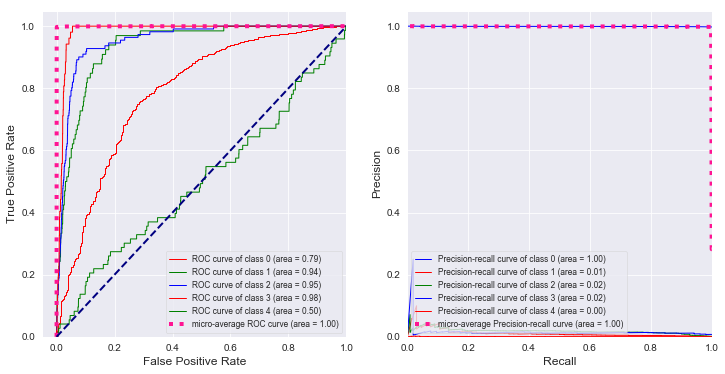

In [44]:
model = 'Logistic Regression B'

clf_lgrb = OneVsRestClassifier(LogisticRegression(random_state=123))
gs_params = {'estimator__C': [.01, 0.1, 1.0, 10], 'estimator__solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'


clf_lgrb, y_pred_lgrb, y_score_lgrb = multiclass_classify(model, clf_lgrb, features_orig, params=gs_params, score=gs_score, scale=False, OvR=False)
print('\nBest Parameters:\n',clf_lgrb)

metrics_lgrb, prc_lgrb, roc_lgrb = multiclass_metrics(model, y_test, y_pred_lgrb, y_score_lgrb, print_out=True, plot_out=True)



Best Parameters:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


-----------------------------------------------------------
Random Forest B 

Confusion Matrix:
[[122018      0      0      0      0]
 [    66      0      0      0      0]
 [   111      0      0      0      0]
 [    52      0      0      0      0]
 [    73      0      0      0      0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    122018
           1       0.00      0.00      0.00        66
           2       0.00      0.00      0.00       111
           3       0.00      0.00      0.00        52
           4       0.00      0.00      0.00        73

    accuracy                           1.00    122320
   macro avg       0.20      0.20      0.20    122320
weighted avg       1.00      1.00      1.00    122320


Metrics:
                 Random Forest B
Accuracy                0.997531
macro F1                0.199753
micro F1                0.997531
macro Precision         0.199506
micro Precision         0

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


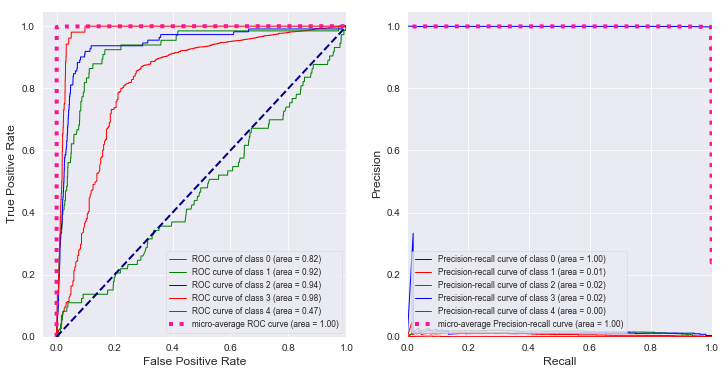

In [45]:
model = 'Random Forest B'
clf_rfcb = RandomForestClassifier(n_estimators=50, random_state=123)
gs_params = {'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'


clf_rfcb, y_pred_rfcb, y_score_rfcb = multiclass_classify(model, clf_rfcb, features_orig, params=gs_params, score=gs_score, scale=False)
print('\nBest Parameters:\n',clf_rfcb)

metrics_rfcb, prc_rfcb, roc_rfcb = multiclass_metrics(model, y_test, y_pred_rfcb, y_score_rfcb, print_out=True, plot_out=True)




Best Parameters:
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
                     weights='uniform')


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


-----------------------------------------------------------
KNN B 

Confusion Matrix:
[[122018      0      0      0      0]
 [    66      0      0      0      0]
 [   111      0      0      0      0]
 [    52      0      0      0      0]
 [    73      0      0      0      0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    122018
           1       0.00      0.00      0.00        66
           2       0.00      0.00      0.00       111
           3       0.00      0.00      0.00        52
           4       0.00      0.00      0.00        73

    accuracy                           1.00    122320
   macro avg       0.20      0.20      0.20    122320
weighted avg       1.00      1.00      1.00    122320


Metrics:
                    KNN B
Accuracy         0.997531
macro F1         0.199753
micro F1         0.997531
macro Precision  0.199506
micro Precision  0.997531
macro Recall     0.200000
micro Recall     0

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


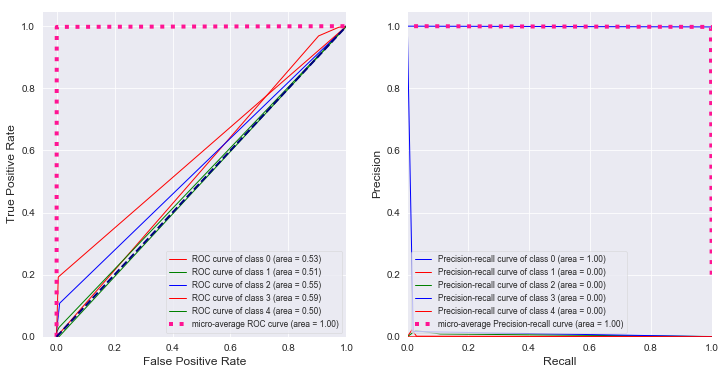

In [46]:
model = 'KNN B'
clf_knnb = KNeighborsClassifier(n_jobs=-1)
gs_params = {'n_neighbors': [9, 10, 11, 12, 13]}
gs_score = 'roc_auc'


clf_knnb, y_pred_knnb, y_score_knnb = multiclass_classify(model, clf_knnb, features_orig, params=gs_params, score=gs_score, scale=False)
print('\nBest Parameters:\n', clf_knnb)

metrics_knnb, prc_knnb, roc_knnb = multiclass_metrics(model, y_test, y_pred_knnb, y_score_knnb, print_out=True, plot_out=True)



Best Parameters:
 OneVsRestClassifier(estimator=GaussianNB(priors=None, var_smoothing=1e-09),
                    n_jobs=None)
-----------------------------------------------------------
Gaussian NB B 

Confusion Matrix:
[[121458     33     53    474      0]
 [    62      2      0      2      0]
 [   106      0      2      3      0]
 [    44      1      1      6      0]
 [    72      0      0      1      0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    122018
           1       0.06      0.03      0.04        66
           2       0.04      0.02      0.02       111
           3       0.01      0.12      0.02        52
           4       0.00      0.00      0.00        73

    accuracy                           0.99    122320
   macro avg       0.22      0.23      0.22    122320
weighted avg       1.00      0.99      0.99    122320


Metrics:
                 Gaussian NB B
Accuracy              0.987009
ma

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


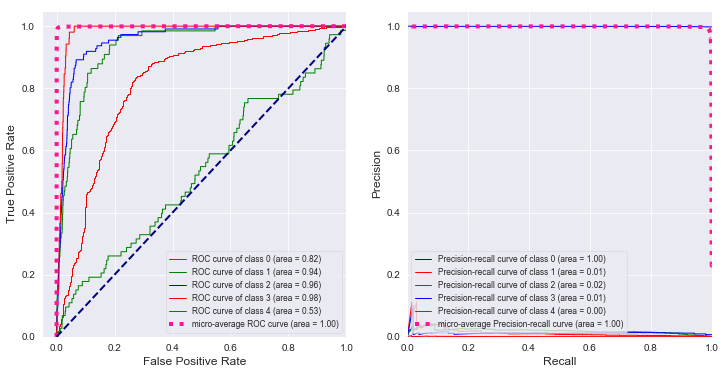

In [47]:
model = 'Gaussian NB B'
clf_gnbb = OneVsRestClassifier(GaussianNB())
gs_params = {} 
gs_score = 'roc_auc'


clf_gnbb, y_pred_gnbb, y_score_gnbb = multiclass_classify(model, clf_gnbb, features_orig, params=gs_params, score=gs_score, scale=False, OvR=False)
print('\nBest Parameters:\n', clf_gnbb)

metrics_gnbb, prc_gnbb, roc_gnbb = multiclass_metrics(model, y_test, y_pred_gnbb, y_score_gnbb, print_out=True, plot_out=True)



Best Parameters:
 MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=123, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


-----------------------------------------------------------
Neural Net MLP B 

Confusion Matrix:
[[122018      0      0      0      0]
 [    66      0      0      0      0]
 [   111      0      0      0      0]
 [    52      0      0      0      0]
 [    73      0      0      0      0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    122018
           1       0.00      0.00      0.00        66
           2       0.00      0.00      0.00       111
           3       0.00      0.00      0.00        52
           4       0.00      0.00      0.00        73

    accuracy                           1.00    122320
   macro avg       0.20      0.20      0.20    122320
weighted avg       1.00      1.00      1.00    122320


Metrics:
                 Neural Net MLP B
Accuracy                 0.997531
macro F1                 0.199753
micro F1                 0.997531
macro Precision          0.199506
micro Precision    

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


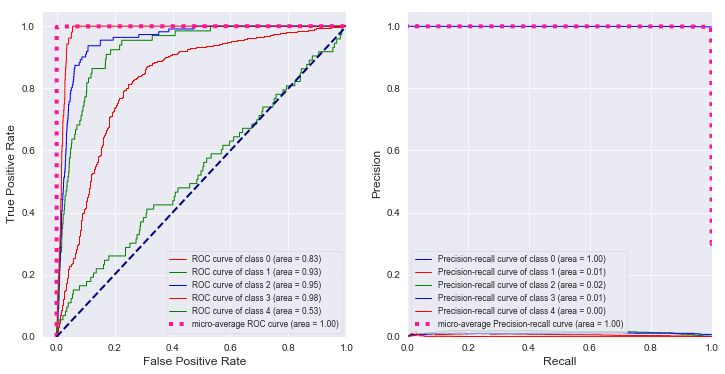

In [48]:
model = 'Neural Net MLP B'
clf_nncb = MLPClassifier(solver='adam', random_state=123)
gs_params = {'alpha': [0.001, 0.01], 'hidden_layer_sizes': [(100,), (100,100)]}
gs_score = 'roc_auc'


clf_nncb, y_pred_nncb, y_score_nncb = multiclass_classify(model, clf_nncb, features_orig, params=gs_params, score=gs_score, scale=True, OvR=False)
print('\nBest Parameters:\n',clf_nncb)

metrics_nncb, prc_nncb, roc_nncb = multiclass_metrics(model, y_test, y_pred_nncb, y_score_nncb, print_out=True, plot_out=True)


In [49]:
#compare all models
metrics_mc = pd.concat([metrics_dtrb, metrics_svlb, metrics_rfcb, metrics_knnb, metrics_gnbb, metrics_nncb], axis=1).T
metrics_mc

,Accuracy,macro F1,micro F1,macro Precision,micro Precision,macro Recall,micro Recall,macro ROC AUC,micro ROC AUC
Decision Tree B,0.997482,0.199748,0.997490,0.199506,0.997498,0.19999,0.997482,0.802015,0.999484
SVC Linear B,0.997531,0.199753,0.997531,0.199506,0.997531,0.20000,0.997531,0.662290,0.999028
Random Forest B,0.997531,0.199753,0.997531,0.199506,0.997531,0.20000,0.997531,0.827784,0.999655
KNN B,0.997531,0.199753,0.997531,0.199506,0.997531,0.20000,0.997531,0.536305,0.998565
Gaussian NB B,0.987009,0.213291,0.990064,0.213884,0.988302,0.24696,0.991833,0.844754,0.999412
Neural Net MLP B,0.997531,0.199753,0.997531,0.199506,0.997531,0.20000,0.997531,0.845291,0.999677
